<a href="https://colab.research.google.com/github/VARDHAN-BORA/Neural-Network-Project3/blob/main/Project_Three_Venkata_Sai_VardhanBora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class BirdSoundsDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_paths = sorted([os.path.join(root, 'images', img) for img in os.listdir(os.path.join(root, 'images'))])
        self.mask_paths = sorted([os.path.join(root, 'masks', img) for img in os.listdir(os.path.join(root, 'masks'))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
        return image, mask

# Data transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

train_dataset = BirdSoundsDataset(root='/content/drive/My Drive/bird sounds/train', transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = BirdSoundsDataset(root='/content/drive/My Drive/bird sounds/valid', transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = BirdSoundsDataset(root='/content/drive/My Drive/bird sounds/test', transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Build an image segmentation model using pytorch

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.upconv4 = self.upconv_block(512, 256)
        self.upconv3 = self.upconv_block(512, 128)  # 256 + 256 (skip connection)
        self.upconv2 = self.upconv_block(256, 64)   # 128 + 128 (skip connection)
        self.upconv1 = self.upconv_block(128, 64)   # 64 + 64 (skip connection)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        # Decoding path
        dec4 = self.upconv4(enc4)
        dec4 = torch.cat((dec4, nn.functional.interpolate(enc3, size=dec4.shape[2:], mode='bilinear', align_corners=False)), dim=1)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, nn.functional.interpolate(enc2, size=dec3.shape[2:], mode='bilinear', align_corners=False)), dim=1)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, nn.functional.interpolate(enc1, size=dec2.shape[2:], mode='bilinear', align_corners=False)), dim=1)
        dec1 = self.upconv1(dec2)

        output = self.final_conv(dec1)
        return torch.sigmoid(output)

# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

Validation Epoch 1/20: 100%|██████████| 25/25 [04:49<00:00, 11.59s/it, Loss=0.122]


Epoch 1/20, Train Loss: 0.2142, Val Loss: 0.1230
Saved Best Model with Val Loss: 0.1230


Validation Epoch 2/20: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, Loss=0.0738]


Epoch 2/20, Train Loss: 0.1200, Val Loss: 0.0914
Saved Best Model with Val Loss: 0.0914


Validation Epoch 3/20: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, Loss=0.0674]


Epoch 3/20, Train Loss: 0.1018, Val Loss: 0.0862
Saved Best Model with Val Loss: 0.0862


Validation Epoch 4/20: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, Loss=0.0724]


Epoch 4/20, Train Loss: 0.0943, Val Loss: 0.0875


Validation Epoch 5/20: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, Loss=0.0597]


Epoch 5/20, Train Loss: 0.0882, Val Loss: 0.0808
Saved Best Model with Val Loss: 0.0808


Validation Epoch 6/20: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, Loss=0.057]


Epoch 6/20, Train Loss: 0.0824, Val Loss: 0.0742
Saved Best Model with Val Loss: 0.0742


Validation Epoch 7/20: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, Loss=0.0522]


Epoch 7/20, Train Loss: 0.0812, Val Loss: 0.0719
Saved Best Model with Val Loss: 0.0719


Validation Epoch 8/20: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s, Loss=0.0529]


Epoch 8/20, Train Loss: 0.0775, Val Loss: 0.0740


Validation Epoch 9/20: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, Loss=0.0519]


Epoch 9/20, Train Loss: 0.0778, Val Loss: 0.0702
Saved Best Model with Val Loss: 0.0702


Validation Epoch 10/20: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, Loss=0.0549]


Epoch 10/20, Train Loss: 0.0763, Val Loss: 0.0767


Validation Epoch 11/20: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, Loss=0.0504]


Epoch 11/20, Train Loss: 0.0739, Val Loss: 0.0707


Validation Epoch 12/20: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, Loss=0.0517]


Epoch 12/20, Train Loss: 0.0723, Val Loss: 0.0725


Validation Epoch 13/20: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0514]


Epoch 13/20, Train Loss: 0.0727, Val Loss: 0.0693
Saved Best Model with Val Loss: 0.0693


Validation Epoch 14/20: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s, Loss=0.0473]


Epoch 14/20, Train Loss: 0.0723, Val Loss: 0.0681
Saved Best Model with Val Loss: 0.0681


Validation Epoch 15/20: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, Loss=0.0507]


Epoch 15/20, Train Loss: 0.0690, Val Loss: 0.0703


Validation Epoch 16/20: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, Loss=0.047]


Epoch 16/20, Train Loss: 0.0691, Val Loss: 0.0676
Saved Best Model with Val Loss: 0.0676


Validation Epoch 17/20: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s, Loss=0.0457]


Epoch 17/20, Train Loss: 0.0682, Val Loss: 0.0668
Saved Best Model with Val Loss: 0.0668


Validation Epoch 18/20: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, Loss=0.0548]


Epoch 18/20, Train Loss: 0.0662, Val Loss: 0.0770


Validation Epoch 19/20: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, Loss=0.0499]


Epoch 19/20, Train Loss: 0.0679, Val Loss: 0.0705


Validation Epoch 20/20: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0469]


Epoch 20/20, Train Loss: 0.0661, Val Loss: 0.0703


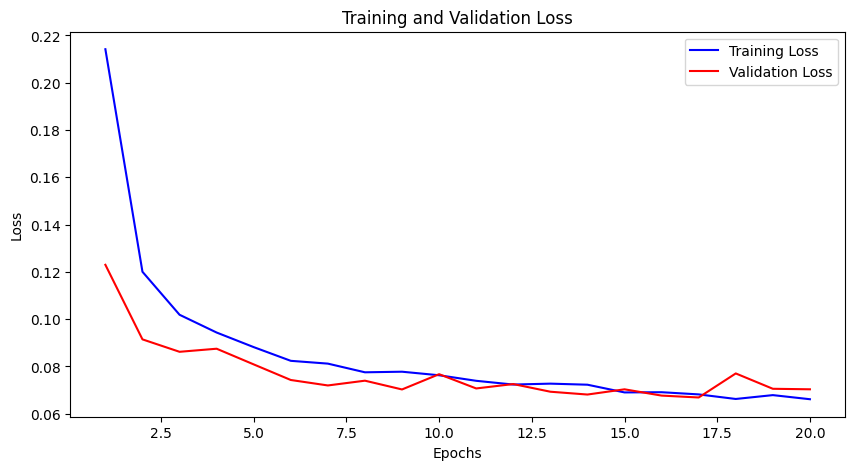

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, criterion, and optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
best_val_loss = float('inf')

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (images, masks) in train_pbar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Resize masks to match the output size
        masks = nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_pbar.set_postfix({'Loss': loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{num_epochs}')
    with torch.no_grad():
        for batch_idx, (images, masks) in val_pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Resize masks to match the output size
            masks = nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')

            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            val_pbar.set_postfix({'Loss': loss.item()})

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:  # Save the model if validation loss decreases
        best_val_loss = val_loss
        model_save_path = '/content/drive/My Drive/bird sounds/best_model.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f'Saved Best Model with Val Loss: {best_val_loss:.4f}')

# Plotting the losses
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3.Evaluate your model using the test images

In [ ]:
# Define the IoU metric
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    true_mask = (true_mask > threshold).float()
    intersection = (pred_mask * true_mask).sum(dim=(1, 2, 3))
    union = pred_mask.sum(dim=(1, 2, 3)) + true_mask.sum(dim=(1, 2, 3)) - intersection
    iou = intersection / (union + 1e-6)
    return iou.mean().item()

# Data transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the saved model
model_path = '/content/drive/My Drive/bird sounds/best_model.pth'

# Load the test dataset and dataloader
test_dataset = BirdSoundsDataset(root='/content/drive/My Drive/bird sounds/test', transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the best saved model
model = UNet().to(device)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the test data
    test_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        test_pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Testing')
        for batch_idx, (images, masks) in test_pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Resize masks to match the output size
            masks = nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')

            iou = calculate_iou(outputs, masks)
            test_iou += iou * images.size(0)
            num_samples += images.size(0)

            test_pbar.set_postfix({'IoU': iou})

    # Calculate average IoU over the test set
    test_iou /= num_samples

    print(f'Test IoU: {test_iou:.4f}')
else:
    print("Model file not found. Please check the path.")

Testing: 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, IoU=0.514]

Test IoU: 0.6320


# 4. Your IoU score should be higher than 60

The printed test IoU score is 0.6320, which is 63.20%. This confirms that model's performance on the test dataset meets the threshold Needed.

# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://www.researchgate.net/publication/382943380_Image_Segmentation_Using_UNet

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 0.85 -->10 points
     < 0.8  --> 0 points
     >= 0.8 & < 0.85  --> 2 point/0.01 higher
     

(6). Discussion - 10 points